# The General Claims Data
- Primary question of interest: Who was at fault?
<br> <br>
- Secondary questions of interest:
    - What Claim Group should the claim be routed to?
    - Can we predict severity type (minor, moderate, major, life threatening, death)
    - What was the cause of the loss?

In [1]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_lg

In [366]:
import matplotlib.pyplot as plt

%matplotlib inline
# Increasing default figure size of the notebook
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 18

In [3]:
import nltk
from nltk import word_tokenize

In [4]:
from nltk.corpus import stopwords
# stop = stopwords.words('english')

In [5]:
stop = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 
 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 
 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 
 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 
 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 
 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 
 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 
 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 
 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'doing', 'it', 'how', 'further', 'was', 
 'here', 'than']

In [6]:
import gensim

In [7]:
# general_tokens_df = pd.read_csv('data/general_with_tokens.csv')

In [8]:
# general_tokens_df.head()

In [9]:
from ast import literal_eval

In [10]:
# def join_strings(df, columns):
#     n_df = df
#     for col in columns:
#         def join_col(row):
#             claim_list = row[col]
#             return ' '.join(claim_list)
#         n_df[col] = n_df.apply(join_col, axis = 1)
#     return n_df
# convert lists from strings back to lists
def convert_to_list(df,cols):
    n_df = df
    for col in cols:
        def de_list(row):
            list_str = row[col]
            return literal_eval(list_str)
        n_df[col] = n_df.apply(de_list, axis = 1)
    return n_df

In [11]:
# general_tokens_df = convert_to_list(general_tokens_df, ['claim_level_list', 'exposure_level_list',
#                                                        'accident_desc_list', 'injury_desc_list',
#                                                        'damage_desc_list'])

In [12]:
general_df = pd.read_csv('data/general_with_word_counts.csv')


In [197]:
general_df = general_df.dropna(subset=['FaultRatingName'])

In [13]:
general_df.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,...,insd_count,insured_count,rear_count,deployed_count,towed_count,totaled_count,head_count,ambulance_count,concussion_count,whiplash_count
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,...,0,0,0,0,0,0,0,0,0,0
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,...,0,2,0,0,0,0,0,0,0,0
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,...,4,4,1,0,0,0,0,0,0,0
3,10003,131008,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,...,4,4,1,0,0,0,0,0,0,0
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,...,0,10,0,0,0,0,0,0,0,0


In [14]:
general_df.claim_level_list.head()

0    reviewed coverage sc rated policy loss effecti...
1    c dol tol pm venue fl location jacksonville fl...
2    insured hospital lost service middle claim ins...
3    insured hospital lost service middle claim ins...
4    adjuster office reassigned adjuster office rea...
Name: claim_level_list, dtype: object

In [198]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119271 entries, 0 to 119271
Data columns (total 47 columns):
ClaimID_RGEN                      119271 non-null int64
ExposureID_RGEN                   119271 non-null int64
ClaimLevelBody                    119271 non-null object
ExposureLevelBody                 119271 non-null object
AccidentDescription               119271 non-null object
InjuryDescription                 119271 non-null object
DamageDescription                 119271 non-null object
SeverityTypeName                  86720 non-null object
ClaimGroup                        119256 non-null object
FaultRatingName                   119271 non-null object
LossCauseName                     119271 non-null object
CCCreateTime                      119271 non-null object
CloseDate                         99600 non-null object
StateName                         119271 non-null object
ClaimLevelBody_preprocess         119271 non-null object
ExposureLevelBody_preprocess      1192

In [16]:
# general_no_unknown = general_df.loc[general_df.loc[:,'FaultRatingName'] != 'Fault unknown',:].reset_index(drop=True)

In [17]:
general_df = general_df.fillna({'exposure_level_list':' ', 'injury_desc_list':' ', 'damage_desc_list': ' '})

In [18]:
# general_no_unknown.info()

In [19]:
# nlp = en_core_web_lg.load()

In [20]:
def column_to_list_text(df, col_name):
    return df[col_name].tolist()

In [21]:
def lower_columns(df, col_list):
    n_df = df
    for col_name in col_list:
        n_col = col_name + '_preprocess'
        n_df[n_col] = n_df[col_name].str.lower()
    return n_df

In [22]:
# lowered_df = lower_columns(general_df, ['ClaimLevelBody', 'ExposureLevelBody', 'AccidentDescription', 
#                                         'InjuryDescription', 'DamageDescription'])

In [23]:
# lowered_df.head()

In [24]:
def tokenize_claim_level(row):
#     list_cols = [['ClaimLevelBody_preprocess', 'ExposureLevelBody_preprocess', 'AccidentDescription_preprocess', 
#                                         'InjuryDescription_preprocess', 'DamageDescription_preprocess']]
    text = row['ClaimLevelBody_preprocess']
    text_tokenize = [token for token in word_tokenize(text) if token.isalpha() and token not in stop]
    return text_tokenize
        
def pre_process(df, col_list):
    for col in col_list:
        df[col] = df.apply(lambda x: tokenize(x, col), axis=1)
    return df

In [25]:
#lowered_df['ClaimLevelBody_preprocess'] = lowered_df.apply(tokenize_claim_level, axis = 1)

In [26]:
#out_df.head()

In [27]:
general_df.claim_level_list[10000]

'witnesses report insured doesnt info caller id claim taken by summer e dol ymm nissan sentra mother reg owner damaris delgado driver airbags none seatbelt yes passengers richard delgado ichabob trail longwood fl lol us hwy unknown cross street unfamiliar area weather clear traffic moderate fol heading back home far left lane witness said clmt coming parking lot trying beat traffic ran right insd insd vehicle went median oncoming traffic ran cinder block wall lanes direction insd far left lane south side clmt vehicle came right saw seconds tried swerve couldnt came plaza poi iv front right fender passenger doors rear qp poi cv drivers side door fenders vehicle towed iv speed limits insd traveling mph police castleberry pd clmt cited careless driving unknown second one injured left hip woke pain hasnt sought med tx going tx aaa adv coll ded pip rental policy adv option file cc contact adv pip adjuster assigned handle injury claim fault covg us ph dcv mld call letter mld call latter ivp 

In [28]:
# lowered_df.head()

In [29]:
fault_ratings = column_to_list_text(general_df, 'FaultRatingName')

In [30]:
claim_level_body = column_to_list_text(general_df, 'claim_level_list')

In [31]:
exposure_level_body = column_to_list_text(general_df, 'exposure_level_list')

In [32]:
accident_description = column_to_list_text(general_df, 'accident_desc_list')

In [33]:
injury_description = column_to_list_text(general_df, 'injury_desc_list')

In [34]:
damage_description = column_to_list_text(general_df, 'damage_desc_list')

In [35]:
# claim_level_tokenized = [[token for token in word_tokenize(doc)] 
#                            for doc in claim_level_body]
# exposure_level_tokenized = [[token for token in word_tokenize(doc)] 
#                            for doc in exposure_level_body]
# accident_desc_tokenized = [[token for token in word_tokenize(doc)] 
#                            for doc in accident_description]
# injury_desc_tokenized = [[token for token in word_tokenize(doc)] 
#                            for doc in injury_description]
# damage_desc_tokenized = [[token for token in word_tokenize(doc) ] 
#                          for doc in damage_description]

# [token for token in word_tokenize(damage_description) if token.isalpha()]

In [36]:
from collections import Counter

In [37]:
# exposure_level_tokenized[4]

In [38]:
# word_counts_claim = [dict(Counter(doc)) for doc in claim_level_tokenized]
# word_counts_exposure = [dict(Counter(doc)) for doc in exposure_level_tokenized]
# word_counts_accident = [dict(Counter(doc)) for doc in accident_desc_tokenized]
# word_counts_injury = [dict(Counter(doc)) for doc in injury_desc_tokenized]
# word_counts_damage = [dict(Counter(doc)) for doc in damage_desc_tokenized]

In [39]:
# word_counts_accident[30052]

In [40]:
# claim_word_counts = [len(doc) for doc in claim_level_tokenized]
# exposure_word_counts = [len(doc) for doc in exposure_level_tokenized]
# accident_word_counts = [len(doc) for doc in accident_desc_tokenized]
# injury_word_counts = [len(doc) for doc in injury_desc_tokenized]
# damage_word_counts = [len(doc) for doc in damage_desc_tokenized]


In [41]:
# iv_list = [0] * len(word_counts_claim)
# liability_list = [0] * len(word_counts_claim)
# dcv_list = [0] * len(word_counts_claim)
# inj_list = [0] * len(word_counts_claim)
# vnop_list = [0] * len(word_counts_claim)
# ac_list = [0] * len(word_counts_claim)
# cv_list = [0] * len(word_counts_claim)
# div_list = [0] * len(word_counts_claim)
# insd_list = [0] * len(word_counts_claim)
# insured_list = [0] * len(word_counts_claim)
# clmt_list = [0] * len(word_counts_claim)

In [42]:
# head_list = [0] * len(word_counts_injury)
# ambulance_list = [0] * len(word_counts_injury)
# concussion_list = [0] * len(word_counts_injury)
# whiplash_list = [0] * len(word_counts_injury)

In [43]:
# rear_list = [0] * len(word_counts_accident)

In [44]:
# deployed_list = [0] * len(word_counts_damage)
# towed_list = [0] * len(word_counts_damage)
# totaled_list = [0] * len(word_counts_damage)

In [45]:
# for ind, count_dict in enumerate(word_counts_accident):
#     if 'rear' in count_dict:
#         rear_list[ind] = count_dict['rear']

In [46]:
# for ind, count_dict in enumerate(word_counts_damage):
#     if 'deployed' in count_dict:
#         deployed_list[ind] = count_dict['deployed']
#     if 'towed' in count_dict:
#         towed_list[ind] = count_dict['towed']
#     if 'totaled' in count_dict:
#         totaled_list[ind] = count_dict['totaled']

In [47]:
# for ind, count_dict in enumerate(word_counts_injury):
#     if 'head' in count_dict:
#         head_list[ind] = count_dict['head']
#     if 'ambulance' in count_dict:
#         ambulance_list[ind] = count_dict['ambulance']
#     if 'concussion' in count_dict:
#         concussion_list[ind] = count_dict['concussion']
#     if 'whiplash' in count_dict:
#         whiplash_list[ind] = count_dict['whiplash']

In [48]:
# for ind, count_dict in enumerate(word_counts_claim):
#     if 'iv' in count_dict:
#         iv_list[ind] = count_dict['iv']
#     else:
#         iv_list[ind] = 0
#     if 'liability' in count_dict:
#         liability_list[ind] = count_dict['liability']
#     else:
#         liability_list[ind] = 0
#     if 'dcv' in count_dict:
#         dcv_list[ind] = count_dict['dcv']
#     else:
#         dcv_list[ind] = 0
#     if 'inj' in count_dict:
#         inj_list[ind] = count_dict['inj']
#     else:
#         inj_list[ind] = 0
#     if 'vnop' in count_dict:
#         vnop_list[ind] = count_dict['vnop']
#     else:
#         vnop_list[ind] = 0
#     if 'ac' in count_dict:
#         ac_list[ind] = count_dict['ac']
#     else:
#         ac_list[ind] = 0
#     if 'cv' in count_dict:
#         cv_list[ind] = count_dict['cv']
#     else:
#         cv_list[ind] = 0
#     if 'div' in count_dict:
#         div_list[ind] = count_dict['div']
#     else:
#         div_list[ind] = 0
#     if 'insd' in count_dict:
#         insd_list[ind] = count_dict['insd']
#     else:
#         insd_list[ind] = 0
#     if 'insured' in count_dict:
#         insured_list[ind] = count_dict['insured']
#     else:
#         insured_list[ind] = 0

In [49]:
# iv_list[:10]

In [50]:
# word_counts_claim[2]

In [51]:
# word_cols = {'claim_level_word_count': claim_word_counts,
#              'exposure_word_count': exposure_word_counts,
#              'accident_desc_word_count': accident_word_counts,
#     'injury_desc_word_count': injury_word_counts,
#              'damage_desc_word_count': damage_word_counts,
#     'iv_count': iv_list,
#          'liability_count': liability_list,
#          'dcv_count': dcv_list,
#          'inj_count': inj_list,
#              'vnop_count': vnop_list,
#             'ac_count': ac_list,
#             'cv_count': cv_list,
#             'div_count': div_list,
#             'insd_count': insd_list,
#             'insured_count': insured_list,
#             'rear_count': rear_list,
#             'deployed_count': deployed_list,
#             'towed_count': towed_list,
#             'totaled_count': totaled_list,
#             'head_count': head_list,
#             'ambulance_count': ambulance_list,
#             'concussion_count': concussion_list,
#             'whiplash_count': whiplash_list}
# df_spec_word_count = pd.DataFrame.from_dict(word_cols)

In [52]:
# df_spec_word_count.head()

In [53]:
# dict_cols = {'word_counts_claim': word_counts_claim,
#          'word_counts_exposure': word_counts_exposure,
#          'word_counts_accident': word_counts_accident,
#          'word_counts_injury': word_counts_injury,
#              'word_counts_damage': word_counts_damage}
# df_word_count = pd.DataFrame.from_dict(dict_cols)

In [54]:
# df_word_count.head()

In [55]:
# token_cols = {'claim_level_list': claim_level_tokenized,
#          'exposure_level_list': exposure_level_tokenized,
#          'accident_desc_list': accident_desc_tokenized,
#          'injury_desc_list': injury_desc_tokenized,
#              'damage_desc_list': damage_desc_tokenized}
# df = pd.DataFrame.from_dict(token_cols)

In [56]:
# df.head()

In [57]:
# len(df)

In [58]:
# df_spec_word_counts = pd.concat([df_with_counts, df_spec_word_count], axis = 1)

In [59]:
# df_with_tokens = pd.concat([lowered_df, df], axis = 1)

In [60]:
# df_with_counts = pd.concat([general_df, df_spec_word_count], axis = 1)

In [61]:
general_df.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,...,insd_count,insured_count,rear_count,deployed_count,towed_count,totaled_count,head_count,ambulance_count,concussion_count,whiplash_count
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,...,0,0,0,0,0,0,0,0,0,0
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,...,0,2,0,0,0,0,0,0,0,0
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,...,4,4,1,0,0,0,0,0,0,0
3,10003,131008,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,...,4,4,1,0,0,0,0,0,0,0
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,...,0,10,0,0,0,0,0,0,0,0


In [62]:
# len(df_with_tokens)

In [63]:
# df_with_counts.to_csv('data/general_with_word_counts.csv', index = False)

In [64]:
# lowered_df.FaultRatingName.value_counts()


In [65]:
# general_tokens_df.iloc[0,22]

In [66]:
def join_strings(df, columns):
    n_df = df
    for col in columns:
        def join_col(row):
            claim_list = row[col]
            return ' '.join(claim_list)
        n_df[col] = n_df.apply(join_col, axis = 1)
    return n_df

In [67]:
# general_full_strings = join_strings(df_with_tokens, ['claim_level_list', 'exposure_level_list',
#                                                        'accident_desc_list', 'injury_desc_list',
#                                                        'damage_desc_list'])

In [68]:
# general_full_strings.head()

In [69]:
general_df.columns

Index(['ClaimID_RGEN', 'ExposureID_RGEN', 'ClaimLevelBody',
       'ExposureLevelBody', 'AccidentDescription', 'InjuryDescription',
       'DamageDescription', 'SeverityTypeName', 'ClaimGroup',
       'FaultRatingName', 'LossCauseName', 'CCCreateTime', 'CloseDate',
       'StateName', 'ClaimLevelBody_preprocess',
       'ExposureLevelBody_preprocess', 'AccidentDescription_preprocess',
       'InjuryDescription_preprocess', 'DamageDescription_preprocess',
       'claim_level_list', 'exposure_level_list', 'accident_desc_list',
       'injury_desc_list', 'damage_desc_list', 'claim_level_word_count',
       'exposure_word_count', 'accident_desc_word_count',
       'injury_desc_word_count', 'damage_desc_word_count', 'iv_count',
       'liability_count', 'dcv_count', 'inj_count', 'vnop_count', 'ac_count',
       'cv_count', 'div_count', 'insd_count', 'insured_count', 'rear_count',
       'deployed_count', 'towed_count', 'totaled_count', 'head_count',
       'ambulance_count', 'concussion_cou

## Model using the word counts for certain words

In [70]:
general_df.loc[:,'claim_level_word_count':].head()

,claim_level_word_count,exposure_word_count,accident_desc_word_count,injury_desc_word_count,damage_desc_word_count,iv_count,liability_count,dcv_count,inj_count,vnop_count,...,insd_count,insured_count,rear_count,deployed_count,towed_count,totaled_count,head_count,ambulance_count,concussion_count,whiplash_count
0,2832,14,10,1,16,38,42,52,14,42,...,0,0,0,0,0,0,0,0,0,0
1,1170,670,12,1,24,6,8,0,0,0,...,0,2,0,0,0,0,0,0,0,0
2,1665,422,8,1,8,32,30,0,0,0,...,4,4,1,0,0,0,0,0,0,0
3,1665,13,8,1,8,32,30,0,0,0,...,4,4,1,0,0,0,0,0,0,0
4,2447,944,4,2,3,3,14,6,6,3,...,0,10,0,0,0,0,0,0,0,0


In [71]:
general_with_dummies = pd.concat([general_df.loc[:,'claim_level_word_count':], 
                                  pd.get_dummies(general_df['FaultRatingName'])], axis=1)

In [72]:
general_with_dummies.head()

,claim_level_word_count,exposure_word_count,accident_desc_word_count,injury_desc_word_count,damage_desc_word_count,iv_count,liability_count,dcv_count,inj_count,vnop_count,...,towed_count,totaled_count,head_count,ambulance_count,concussion_count,whiplash_count,Comparative Negligence,Insured at fault,No fault,Other party at fault
0,2832,14,10,1,16,38,42,52,14,42,...,0,0,0,0,0,0,0,0,0,1
1,1170,670,12,1,24,6,8,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1665,422,8,1,8,32,30,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1665,13,8,1,8,32,30,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2447,944,4,2,3,3,14,6,6,3,...,0,0,0,0,0,0,0,0,0,1


In [73]:
general_df.FaultRatingName.value_counts()

Insured at fault          74304
Other party at fault      29394
Comparative Negligence     8178
No fault                   7395
Name: FaultRatingName, dtype: int64

In [74]:
print('The percentage of "Insured at fault" is : ' + str(round(74304/len(general_df)*100)) + '%')
print('The percentage of "Other party at fault" is : ' + str(round(29394/len(general_df)*100)) + '%')
print('The percentage of "Comparative Negligence" is : ' + str(round(8178/len(general_df)*100)) + '%')
print('The percentage of "No fault" is : ' + str(round(7395/len(general_df)*100)) + '%')

The percentage of "Insured at fault" is : 62%
The percentage of "Other party at fault" is : 25%
The percentage of "Comparative Negligence" is : 7%
The percentage of "No fault" is : 6%


In [75]:
general_with_dummies['Insured at fault'].value_counts()

1    74304
0    44968
Name: Insured at fault, dtype: int64

In [76]:
general_with_dummies['Other party at fault'].value_counts()

0    89878
1    29394
Name: Other party at fault, dtype: int64

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [78]:
import parfit.parfit as pf

In [79]:
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [353]:
X = general_df.loc[:,'claim_level_word_count':'whiplash_count']
y = general_df['FaultRatingName']

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=42)

In [82]:
param_grid = {
    'pca__n_components': [2, 5, 10, 15, 20, 23],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False)

In [83]:
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.692):
{'logistic__alpha': 0.01, 'pca__n_components': 15}


In [84]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   33.0s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   35.8s remaining:   59.7s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   36.4s remaining:   36.4s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  1.0min remaining:   36.7s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  1.0min remaining:   20.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished


-------------SCORING MODELS-------------


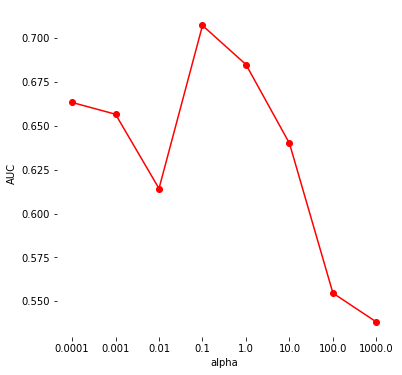

SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.7073402144658035


In [85]:
bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           X_train, y_train, X_test, y_test, 
           metric = roc_auc_score, greater_is_better=True,
           scoreLabel = "AUC")
print(bestModel, bestScore)

In [86]:
model = SGDClassifier(alpha=1.0, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [87]:
model.fit(X_train, y_train)

SGDClassifier(alpha=1.0, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [88]:
predicted_SGD = model.predict(X_test)

In [89]:
np.mean(predicted_SGD == y_test)

0.7539741095982293

In [90]:
model.score(X_test, y_test)

0.7539741095982293

In [91]:
confusion_matrix(y_test, predicted_SGD, labels=None, sample_weight=None)

array([[22052,   396],
       [ 6940,   430]])

## Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [93]:
clf=RandomForestClassifier(n_estimators=100)

In [94]:
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [95]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8798712187269434


In [96]:
confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

array([[21962,   486],
       [ 3096,  4274]])

In [97]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,21962,486,22448
1,3096,4274,7370
All,25058,4760,29818


In [98]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92     22448
           1       0.90      0.58      0.70      7370

   micro avg       0.88      0.88      0.88     29818
   macro avg       0.89      0.78      0.81     29818
weighted avg       0.88      0.88      0.87     29818



In [99]:
print(clf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [100]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 800, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [101]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [103]:
# rf_random.best_params_

## Best parameters from random grid search

{'n_estimators': 207,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [355]:
clf_best=RandomForestClassifier(n_estimators = 207,
 min_samples_split = 5,
 min_samples_leaf = 1,
 max_features = 'sqrt',
 max_depth = None,
 bootstrap = False)

clf_best.fit(X_train,y_train)

y_pred_best=clf_best.predict(X_test)

In [359]:
print("Accuracy:",round(accuracy_score(y_test, y_pred_best), 2))

Accuracy: 0.83


In [360]:
confusion_matrix(y_test, y_pred_best, labels=None, sample_weight=None)

array([[ 1085,   849,    16,   125],
       [   38, 17792,    89,   667],
       [    3,   772,   817,   201],
       [   34,  2096,    64,  5170]])

Improved from 88.1% to 88.95% accuracy

In [361]:
# target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_best))

                        precision    recall  f1-score   support

Comparative Negligence       0.94      0.52      0.67      2075
      Insured at fault       0.83      0.96      0.89     18586
              No fault       0.83      0.46      0.59      1793
  Other party at fault       0.84      0.70      0.76      7364

             micro avg       0.83      0.83      0.83     29818
             macro avg       0.86      0.66      0.73     29818
          weighted avg       0.84      0.83      0.82     29818



In [362]:
pd.crosstab(y_test, y_pred_best, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Comparative Negligence,Insured at fault,No fault,Other party at fault,All
True,,,,,
Comparative Negligence,1085,849,16,125,2075
Insured at fault,38,17792,89,667,18586
No fault,3,772,817,201,1793
Other party at fault,34,2096,64,5170,7364
All,1160,21509,986,6163,29818


In [363]:
feature_importances = pd.DataFrame(clf_best.feature_importances_,
                                  index = X_train.columns,
                                  columns = ['importance']).sort_values('importance', ascending = False)

In [364]:
feature_importances.index.values

array(['claim_level_word_count', 'cv_count', 'iv_count',
       'damage_desc_word_count', 'liability_count', 'insured_count',
       'accident_desc_word_count', 'inj_count', 'exposure_word_count',
       'insd_count', 'injury_desc_word_count', 'rear_count', 'ac_count',
       'vnop_count', 'div_count', 'head_count', 'dcv_count',
       'whiplash_count', 'concussion_count', 'ambulance_count',
       'deployed_count', 'towed_count', 'totaled_count'], dtype=object)

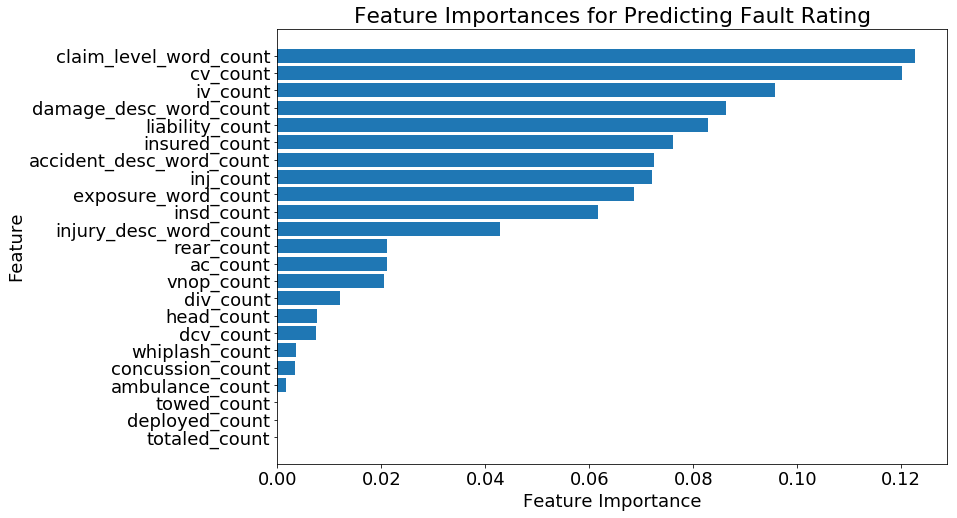

In [368]:
plt.barh(feature_importances.sort_values(by = 'importance').index.values, feature_importances\
         .sort_values(by = 'importance').importance.values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Predicting Fault Rating');

- **cv_count**: Number of times `cv` is used in Claim Level Body
- **claim_level_word_count**: Number of words in Claim Level Body
- **iv_count**: Number of times `iv` is used in Claim Level Body
- **inj_count**: Number of times `inj` is used in Claim Level Body
- **damage_desc_word_count**: Number of words in Damage Description
- **exposure_word_count**: Number of words in Exposure Level Body
- **insured_count**: Number of times `insured` is used in Claim Level Body
- **liability_count**: Number of times `liability` is used in Claim Level Body
- **accident_desc_word_count**: Number of words used in Accident Description
- **insd_count**: Number of times `insd` is used in Claim Level Body
- **injury_desc_word_count**: Number of words in Injury Description
- **ac_count**: Number of times `ac` is used in Claim Level Body
- **rear_count**: Number of times `rear` is used in Accident Description
- **vnop_count**: Number of times `vnop` is used in Claim Level Body
- **div_count**: Number of times `div` is used in Claim Level Body
- **head_count**: Number of times `head` is used in Injury Description
- **dcv_count**: Number of times `dcv` is used in Claim Level Body
- **whiplash_count**: Number of times `whiplash` is used in Injury Description
- **concussion_count**: Number of times `concussion` is used in Injury Description
- **ambulance_count**: Number of times `ambulance` is used in Injury Description

In [112]:
feature_importances

,importance
cv_count,0.133317
claim_level_word_count,0.121836
iv_count,0.091341
inj_count,0.088711
damage_desc_word_count,0.085837
exposure_word_count,0.072406
insured_count,0.070984
liability_count,0.070223
accident_desc_word_count,0.067889
insd_count,0.059492


In [113]:
from sklearn.metrics import roc_curve

In [114]:
y_proba = clf_best.predict_proba(X_test)

In [115]:
y_proba[:10]

array([[0.99637681, 0.00362319],
       [0.58977456, 0.41022544],
       [0.84339775, 0.15660225],
       [0.60909823, 0.39090177],
       [0.85225443, 0.14774557],
       [0.61030596, 0.38969404],
       [0.88566828, 0.11433172],
       [0.00845411, 0.99154589],
       [0.98188406, 0.01811594],
       [0.96457327, 0.03542673]])

In [116]:
y_proba = clf_best.predict_proba(X_test)
threshold = 0.4
pred_proba = np.empty(len(y_proba))
for i in range(len(y_proba)):
    predicted_true = y_proba[i][1]
    if predicted_true > threshold:
        pred_proba[i] = 1
    else: 
        pred_proba[i] = 0

In [117]:
pd.crosstab(y_test, pred_proba, rownames=['True'], colnames=['Predicted'], margins=True)


Predicted,0.0,1.0,All
True,,,
0,21206,1242,22448
1,1964,5406,7370
All,23170,6648,29818


In [118]:
print(classification_report(y_test, pred_proba))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     22448
           1       0.81      0.73      0.77      7370

   micro avg       0.89      0.89      0.89     29818
   macro avg       0.86      0.84      0.85     29818
weighted avg       0.89      0.89      0.89     29818



In [119]:
print("Accuracy:",accuracy_score(y_test, pred_proba))

Accuracy: 0.8924810517137299


In [120]:
roc_curve(y_test, y_pred_best)

(array([0.        , 0.02369922, 1.        ]),
 array([0.        , 0.61967436, 1.        ]),
 array([2, 1, 0]))

## Random Forest Insured at Fault

In [121]:
X_insured = general_with_dummies.loc[:,'claim_level_word_count':'whiplash_count']
y_insured = general_with_dummies['Insured at fault']

In [122]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_insured, y_insured, 
                                                    test_size=0.25, random_state=42)

In [123]:
clf_i=RandomForestClassifier(n_estimators=150)

In [124]:
clf_i.fit(X_train_i,y_train_i)

y_pred_i=clf.predict(X_test_i)

In [125]:
print("Accuracy:",accuracy_score(y_test_i, y_pred_i))

Accuracy: 0.23998926822724528


In [126]:
confusion_matrix(y_test_i, y_pred_i, labels=None, sample_weight=None)

array([[ 6790,  4394],
       [18268,   366]])

In [127]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test_i, y_pred_i))

              precision    recall  f1-score   support

           0       0.27      0.61      0.37     11184
           1       0.08      0.02      0.03     18634

   micro avg       0.24      0.24      0.24     29818
   macro avg       0.17      0.31      0.20     29818
weighted avg       0.15      0.24      0.16     29818



## Sci-kit Learn Model

In [128]:
general_with_dummies.columns

Index(['claim_level_word_count', 'exposure_word_count',
       'accident_desc_word_count', 'injury_desc_word_count',
       'damage_desc_word_count', 'iv_count', 'liability_count', 'dcv_count',
       'inj_count', 'vnop_count', 'ac_count', 'cv_count', 'div_count',
       'insd_count', 'insured_count', 'rear_count', 'deployed_count',
       'towed_count', 'totaled_count', 'head_count', 'ambulance_count',
       'concussion_count', 'whiplash_count', 'Comparative Negligence',
       'Insured at fault', 'No fault', 'Other party at fault'],
      dtype='object')

In [129]:
X_sk = general_df.loc[:,'claim_level_list']
y_sk = general_with_dummies['Insured at fault']

In [130]:
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(X_sk, y_sk, 
                                                    test_size=0.25, random_state=42)

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [132]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

In [133]:
clf_vec = TfidfVectorizer()

In [134]:
model = clf_vec.fit(X_train_sk, y_train_sk)

In [136]:
#y_pred = model.predict(X_test_sk)

In [137]:
# model = text_clf.fit(X_train, y_train)

In [138]:
# predicted_MNB = text_clf.predict(X_test)

In [139]:
# predicted_MNB[:5]

In [140]:
# np.mean(predicted_MNB == y_test)

In [141]:
# len(predicted_MNB)

In [142]:
# text_clf.score(X_test, y_test)

In [143]:
# from collections import Counter

In [144]:
# Counter(predicted_MNB)

In [145]:
# 28402/29818

In [148]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(general_df.claim_level_list).toarray()
# labels = general_df.FaultRatingName
# features.shape

In [150]:
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], 
#                                                     random_state = 0)
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [151]:
30453/len(general_df)*100

25.532396539003287

In [152]:
general_df.LossCauseName.value_counts()

IV rear-end CV                           30453
Collision in an intersection             19131
Collision with motor vehicle             17415
Collision while merging / lane change    10514
CV rear-end IV                            9744
Collision while turning left              7560
Collision with fixed object               5852
Rear-end collision                        4525
Collision while backing                   3117
Hit and Run                               2642
Collision with pedestrian                 2321
Collision with a parked car               1342
Rollover                                  1263
Hazardous Condition                        849
Collision with bicycle / motorcycle        820
IV struck by or struck animal              510
IV struck while parked                     386
Falling or moving object                   307
IV theft                                   137
Collision with train or bus                106
Malicious mischief and vandalism            83
Fire         

In [199]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns

In [200]:
train, test = train_test_split(general_df, test_size=0.3, random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


In [283]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['accident_desc_list']), tags=[r.FaultRatingName]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['accident_desc_list']), tags=[r.FaultRatingName]), axis=1)

In [284]:
# train_tagged.values[21]

In [285]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [286]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 83489/83489 [00:00<00:00, 2313621.93it/s]


In [287]:
%%time
for epoch in range(12):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), 
                     total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 83489/83489 [00:00<00:00, 3218520.48it/s]


CPU times: user 38.6 s, sys: 10.1 s, total: 48.7 s
Wall time: 29.1 s


In [288]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=10)) for doc in sents])
    return targets, regressors


In [289]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)



In [290]:
logreg = LogisticRegression(n_jobs=1, C=1e5)

In [291]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/Users/andrewmarsee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/andrewmarsee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.6385612877983343
Testing F1 score: 0.5578827082589081


In [292]:
y_train[1]

'Insured at fault'

In [293]:
# pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [294]:
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

Comparative Negligence       0.49      0.03      0.06      2498
      Insured at fault       0.66      0.94      0.77     22294
              No fault       0.55      0.06      0.11      2141
  Other party at fault       0.49      0.18      0.26      8849

             micro avg       0.64      0.64      0.64     35782
             macro avg       0.55      0.31      0.30     35782
          weighted avg       0.60      0.64      0.56     35782



In [295]:
3*12

36

In [296]:
clf_dvec=RandomForestClassifier(n_estimators=150)

In [297]:
clf_dvec.fit(X_train,y_train)

y_pred_dvec=clf_dvec.predict(X_test)

In [302]:
print("Accuracy:",round(accuracy_score(y_test, y_pred_dvec), 2))

Accuracy: 0.73


In [325]:
prediction_dvec_proba[0:5]

array(['Insured at fault', 'Other party at fault', 'Insured at fault',
       'Other party at fault', 'Insured at fault'], dtype='<U22')

In [326]:
dvec_pred_proba[:10]

array([[0.05333333, 0.61333333, 0.10666667, 0.22666667],
       [0.01333333, 0.22666667, 0.08666667, 0.67333333],
       [0.04666667, 0.63333333, 0.04666667, 0.27333333],
       [0.        , 0.06      , 0.02      , 0.92      ],
       [0.04666667, 0.77333333, 0.04666667, 0.13333333],
       [0.04      , 0.54666667, 0.32666667, 0.08666667],
       [0.09333333, 0.74      , 0.02      , 0.14666667],
       [0.00666667, 0.08      , 0.04      , 0.87333333],
       [0.00666667, 0.83333333, 0.08      , 0.08      ],
       [0.02666667, 0.82666667, 0.02      , 0.12666667]])

In [299]:
print(classification_report(y_test, y_pred_dvec))

                        precision    recall  f1-score   support

Comparative Negligence       0.86      0.18      0.30      2498
      Insured at fault       0.72      0.98      0.83     22294
              No fault       0.70      0.17      0.28      2141
  Other party at fault       0.83      0.41      0.55      8849

             micro avg       0.73      0.73      0.73     35782
             macro avg       0.78      0.43      0.49     35782
          weighted avg       0.75      0.73      0.69     35782



In [300]:
cm_dvec = pd.DataFrame(confusion_matrix(y_test, y_pred_dvec, labels=None, sample_weight=None))
cm_dvec.columns = ['Comparative Negligence', 'Insured at fault', 'No fault', 'Other party at fault']
cm_dvec.index = ['Comparative Negligence', 'Insured at fault', 'No fault', 'Other party at fault']
cm_dvec

,Comparative Negligence,Insured at fault,No fault,Other party at fault
Comparative Negligence,454,1905,13,126
Insured at fault,37,21767,77,413
No fault,8,1581,370,182
Other party at fault,28,5156,69,3596


In [343]:
dvec_pred_proba = clf_dvec.predict_proba(X_test)
threshold_0 = 0.2 # Comparative Negligence
threshold_1 = 0.5 # Insured at fault
threshold_2 = 0.2 # No Fault
threshold_3 = 0.2 # Other party at fault
prediction_dvec_proba = []
for i in range(len(dvec_pred_proba)):
    predicted_true_neg = dvec_pred_proba[i][0]
    predicted_true_insd = dvec_pred_proba[i][1]
    predicted_true_none = dvec_pred_proba[i][2]
    predicted_true_other = dvec_pred_proba[i][3]
    if predicted_true_insd >= threshold_1: # Greater than 0.5 -> "Insured at fault"
        prediction_dvec_proba += ['Insured at fault']
# Otherwise take the max and assign that class
    elif predicted_true_neg > predicted_true_none and predicted_true_neg > predicted_true_other: 
        prediction_dvec_proba += ['Comparative Negligence']
    elif predicted_true_none > predicted_true_neg and predicted_true_none > predicted_true_other: 
        prediction_dvec_proba += ['No fault']
    else:
        prediction_dvec_proba += ['Other party at fault']
prediction_dvec_proba = np.asarray(prediction_dvec_proba)

In [344]:
print("Accuracy:",round(accuracy_score(y_test, prediction_dvec_proba), 2))
print(classification_report(y_test, prediction_dvec_proba))

Accuracy: 0.74
                        precision    recall  f1-score   support

Comparative Negligence       0.81      0.29      0.43      2498
      Insured at fault       0.77      0.91      0.83     22294
              No fault       0.68      0.24      0.36      2141
  Other party at fault       0.64      0.56      0.60      8849

             micro avg       0.74      0.74      0.74     35782
             macro avg       0.72      0.50      0.55     35782
          weighted avg       0.73      0.74      0.72     35782



In [345]:
cm_dvec_proba = pd.DataFrame(confusion_matrix(y_test, prediction_dvec_proba, labels=None, sample_weight=None))
cm_dvec_proba.columns = ['Comparative Negligence', 'Insured at fault', 'No fault', 'Other party at fault']
cm_dvec_proba.index = ['Comparative Negligence', 'Insured at fault', 'No fault', 'Other party at fault']
cm_dvec_proba

,Comparative Negligence,Insured at fault,No fault,Other party at fault
Comparative Negligence,724,1177,22,575
Insured at fault,110,20278,136,1770
No fault,22,1107,524,488
Other party at fault,42,3770,84,4953
